In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import random
import scipy as sp
from scipy.stats import entropy

random.seed(25)

In [2]:
df = pd.read_csv('./data/epfl_data.csv')
df['Stability'] = df['Stability'].map({'s': 1, 'ns': 0}).astype(float)
print(df.shape)

(200000, 259)


In [3]:
df = df[:25]

In [4]:
dfcolumns = df.columns
data = df.values

d = data.shape[1]

mu_ml = np.mean(data, axis=0)
data_cov = np.cov(data, rowvar=False)

In [5]:
q = 100
# Variance
lambdas, eigenvecs = np.linalg.eig(data_cov)
idx = lambdas.argsort()[::-1]
lambdas = lambdas[idx]
eigenvecs = - eigenvecs[:,idx]

var_ml = (1.0 / (d-q)) * sum([lambdas[j] for j in range(q,d)])


# Weight matrix
uq = eigenvecs[:,:q]


lambdaq = np.diag(lambdas[:q])

print(uq.shape)
print(lambdaq.shape)
weight_ml = uq @ np.sqrt(lambdaq - var_ml * np.eye(q))
print(weight_ml.shape)

(259, 100)
(100, 100)
(259, 100)


In [6]:
def sample_hidden_given_visible(
    weight_ml : np.array,
    mu_ml : np.array,
    var_ml : float,
    visible_samples : np.array
    ) -> np.array:

    q = weight_ml.shape[1]
    m = np.transpose(weight_ml) @ weight_ml + var_ml * np.eye(q)

    cov = var_ml * np.linalg.inv(m) @ np.eye(q)
    act_hidden = []
    for data_visible in visible_samples:
        mean = np.linalg.inv(m) @ np.transpose(weight_ml) @ (data_visible - mu_ml)
        sample = np.random.multivariate_normal(mean.real, cov.real, size=1)
        act_hidden.append(sample[0])

    return np.array(act_hidden)

def sample_visible_given_hidden(
    weight_ml : np.array,
    mu_ml : np.array,
    var_ml : float,
    hidden_samples : np.array
    ) -> np.array:

    d = weight_ml.shape[0]

    act_visible = []
    for data_hidden in hidden_samples:
        mean = weight_ml @ data_hidden + mu_ml
        cov = var_ml * np.eye(d)
        sample = np.random.multivariate_normal(mean.real,cov.real,size=1)
        act_visible.append(sample[0])

    return np.array(act_visible)

In [7]:
act_hidden = sample_hidden_given_visible(
    weight_ml=weight_ml,
    mu_ml=mu_ml,
    var_ml=var_ml,
    visible_samples=data
    )

mean_hidden = np.full(q,0)
cov_hidden = np.eye(q)

no_samples = len(data)
samples_hidden = np.random.multivariate_normal(mean_hidden,cov_hidden,size=no_samples)

/tmp/ipykernel_217163/4289726493.py:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sample = np.random.multivariate_normal(mean.real, cov.real, size=1)


In [8]:
generated_samples = sample_visible_given_hidden(
    weight_ml=weight_ml,
    mu_ml=mu_ml,
    var_ml=var_ml,
    hidden_samples=samples_hidden
    )
generated_samples_df = pd.DataFrame(generated_samples, columns=dfcolumns)

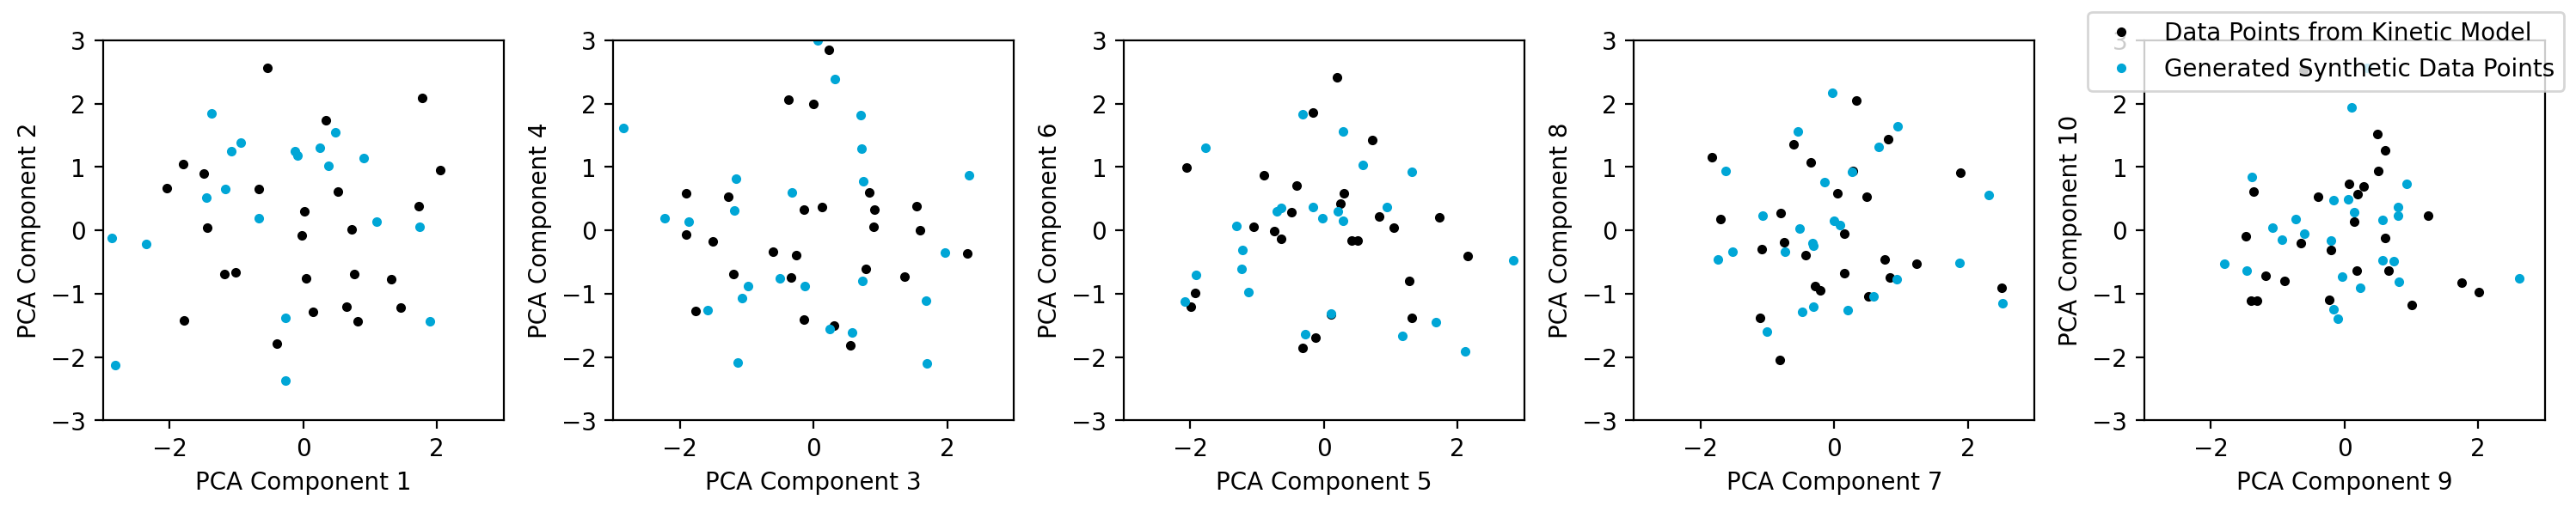

In [9]:
pca_real = PCA(n_components=10, random_state=42)
real_result = pca_real.fit_transform(data)
pca_synthetic = PCA(n_components=10, random_state=42)
synthetic_result = pca_synthetic.fit_transform(generated_samples)

fig, axes = plt.subplots(ncols=5, figsize=(15,3))

for j in range(0, 10, 2):
    index = j
    index2 = j + 1
    arr_idx = j//2
    axes[arr_idx].plot(real_result[:, index], real_result[:, index2],".", color='black')
    axes[arr_idx].plot(synthetic_result[:, index], synthetic_result[:, index2],".", color='#00a6d6')
    axes[arr_idx].set_xlabel(f'PCA Component {index + 1}')
    axes[arr_idx].set_ylabel(f'PCA Component {index2 + 1}')
    axes[arr_idx].axis([-3, 3, -3, 3])
#             axes[i, j].legend(['Data Points from Kinetic Model', 'Generated Synthetic Data Points'], fontsize="15", loc ="upper right")

fig.legend(['Data Points from Kinetic Model', 'Generated Synthetic Data Points'], fontsize="10", loc ="upper right")
fig.set_label('PCA Visualization')
plt.tight_layout(w_pad=1.0)
plt.show()

In [10]:
from scipy.stats import ks_2samp, entropy

for c in dfcolumns:
    ks = ks_2samp(df[c], generated_samples_df[c])
    print(f'KS score for {c}: {ks.statistic} with p-value {ks.pvalue}')
    print("-----------------")
    break

KS score for BIO@atp_c: 0.16 with p-value 0.914993219397903
-----------------


In [11]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

# diagnostic_report = run_diagnostic(
#     real_data=df,
#     synthetic_data=generated_samples_df,
#     metadata=metadata
# )

# quality_report = evaluate_quality(
#     real_data=df,
#     synthetic_data=generated_samples_df,
#     metadata=metadata)